### IMPORTACIÓN DE PAQUETES

In [1]:
!pip install pmdarima

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

### DATA

In [9]:
data = pd.read_excel("/content/Datos Llegadas de Extranjeros - Hasta Marzo 2020.xlsx",parse_dates=True)
df=data.copy()
df.head()

,Via de Ingreso,Cantidad,Date,Nombre Pais,Región
0,Aerop. Juan Santamaria,18524,2020-01-01,Canadá,América Del Norte
1,Aerop. Juan Santamaria,19907,2020-02-01,Canadá,América Del Norte
2,Aerop. Juan Santamaria,8464,2020-03-01,Canadá,América Del Norte
3,Aerop. Juan Santamaria,77973,2020-01-01,Estados Unidos,América Del Norte
4,Aerop. Juan Santamaria,89088,2020-02-01,Estados Unidos,América Del Norte


In [5]:
df.shape
df.dtypes

(13840, 5)

In [10]:
df=df[df['Via de Ingreso']=="Aerop. Juan Santamaria"]
df=df[df['Nombre Pais']=="Estados Unidos"]
df.sort_values('Date',inplace=True)
del df['Via de Ingreso']
del df['Nombre Pais']
del df['Región']

df.head()

,Cantidad,Date
211,61631,2014-01-01
212,62353,2014-02-01
213,76894,2014-03-01
214,54354,2014-04-01
215,51127,2014-05-01


In [11]:
df.Date = pd.to_datetime(df.Date, dayfirst = True)
df.set_index("Date", inplace=True)

df.tail()

,Cantidad
Date,
2019-11-01,59393
2019-12-01,88275
2020-01-01,77973
2020-02-01,89088
2020-03-01,42331


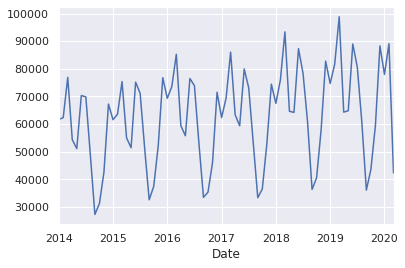

In [14]:
df.Cantidad.plot()

### DESCOMPOSICIÓN DE SERIES 

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

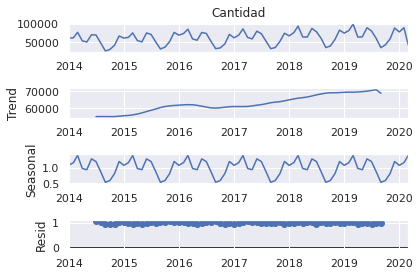

In [13]:
s_desc = seasonal_decompose(df.Cantidad, model="multiplicative")
s_desc.plot()
plt.show()

### ESTACIONALIDAD

In [15]:
df['Mes']=df.index.month
df.head()

,Cantidad,Mes
Date,,
2014-01-01,61631,1
2014-02-01,62353,2
2014-03-01,76894,3
2014-04-01,54354,4
2014-05-01,51127,5


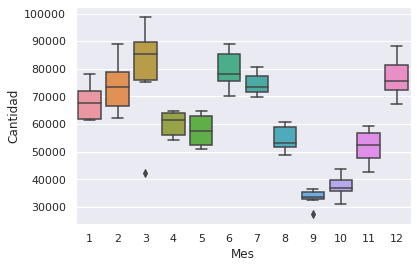

In [16]:
import pandas as pnd
import matplotlib.pyplot as mplt
import seaborn as sbn

#Gráfico
sbn.boxplot(data=df, x='Mes', y='Cantidad')

In [17]:
from pmdarima.arima.utils import nsdiffs

nsdiffs(df.Cantidad,test='ch', m=12)

0

### ESTACIONARIEDAD

In [18]:
from pmdarima.arima.utils import ndiffs

ndiffs(df.Cantidad, test = "pp")

0

#### ADF Test：Augmented Dickey-Fuller Test

In [19]:
from statsmodels.tsa.stattools import adfuller

Ho : La serie No es estacionaria

Ha : La serie es estacionaria

Si el estadístico de contraste calculado es menor al valor crítico se rechaza la Hipótesis Nula.

En valor absoluto: 
Si el estadístico de contraste calculado es mayor en valor absoluto al valor crítico se rechaza la Hipótesis Nula.

Si el valor_p obtenido de la hipótesis es menor que el umbral (generalmente 5%), entonces la Hipótesis Nula no es válida; de lo contrario, la hipótesis Nula es válida.

In [20]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'n_lags: {result[2]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')

adf_test(df.Cantidad)

ADF Statistic: -1.766042021108153
p-value: 0.3974463856480642
n_lags: 12
Critial Values:
   1%, -3.540522678829176
Critial Values:
   5%, -2.9094272025108254
Critial Values:
   10%, -2.5923136524453696
Result: The series is not stationary


#### KPSS Test：Kwiatkowski-Phillips-Schmidt-Shin Test

In [21]:
from statsmodels.tsa.stattools import kpss

Ho: La serie es estacionaria. 

Ha: La serie No es estacionaria.

Si el valor_p obtenido de la hipótesis es menor que el umbral de significancia (generalmente 5%), entonces la Hipótesis Nula no es válida. Es decir, la hipótesis Nula se rechaza.

In [22]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(df.Cantidad)

KPSS Statistic: 0.4948375179292038
p-value: 0.04282938785378294
num lags: 12
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


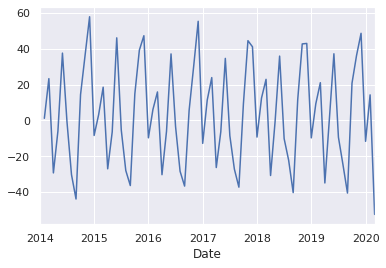

In [24]:
df['returns'] = df.Cantidad.pct_change(1)*100
df.returns.plot()

In [25]:
df.returns.head()

Date
2014-01-01          NaN
2014-02-01     1.171488
2014-03-01    23.320450
2014-04-01   -29.313080
2014-05-01    -5.937006
Name: returns, dtype: float64

### FUNCIONES DE AUTOCORRELACIÓN

In [26]:
import statsmodels.graphics.tsaplots as sgt 

#### AUTOCORRELACIÓN SIMPLE (ACF)

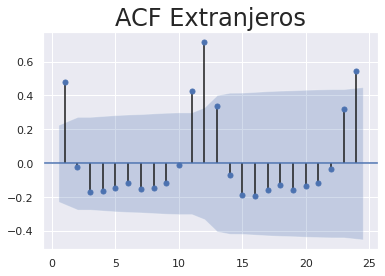

In [27]:
sgt.plot_acf(df.Cantidad, lags = 24, zero = False)
plt.title("ACF Extranjeros", size = 24)
plt.show()

#### AUTOCORRELACIÓN PARCIAL (PACF)

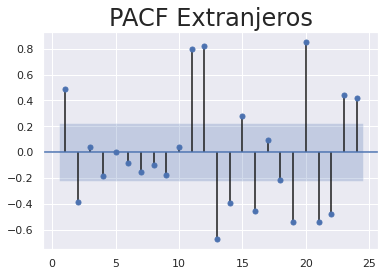

In [28]:
sgt.plot_pacf(df.Cantidad, lags = 24, zero = False, method = ('ols'))
plt.title("PACF Extranjeros", size = 24)
plt.show()

### MODELO

#### Modelo Automático

In [29]:
from pmdarima.arima import auto_arima

In [30]:
size = int(len(df)*0.8)
df_train, df_test = df.iloc[:size], df.iloc[size:]

In [33]:
df.shape

(75, 3)

In [34]:
model = auto_arima(df.Cantidad, m = 12,
                       max_Q =1, max_D = 1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   75
Model:             SARIMAX(3, 0, 5)x(1, 0, [], 12)   Log Likelihood                -793.251
Date:                             Tue, 22 Jun 2021   AIC                           1608.502
Time:                                     20:49:47   BIC                           1633.994
Sample:                                          0   HQIC                          1618.681
                                              - 75                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.069e+04   4.29e+04      0.482      0.629   -6.34e+04    1.05e+05
ar.L1          0.2117      1.766      0.120      0.905      -3.249       3.673
ar.L2         -0.2370      1.200     -0.197      0.843      -2.590       2.115
ar.L3         -0.4087      1.683     -0.243      0.808      -3.708       2.891
ma.L1          0.3676      1.661      0.221      0.825      -2.888       3.623
ma.L2          0.4360      1.430      0.305      0.760      -2.368       3.240
ma.L3          0.4766      1.927      0.247      0.805      -3.301       4.254
ma.L4          0.2775      1.302      0.213      0.831      -2.274       2.829
ma.L5         -0.2090      1.105     -0.189      0.850      -2.375       1.957
ar.S.L12       0.7608      0.175      4.354      0.000       0.418       1.103
sigma2      1.241e+08     19.115   6.49e+06      0.000    1.24e+08    1.24e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1432.88
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               3.62   Skew:                            -3.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.56e+22. Standard errors may be unstable.
"""

In [35]:
model.fit(df_train.Cantidad)

ARIMA(maxiter=50, method='lbfgs', order=(3, 0, 5), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 0, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [36]:
future_forecast = model.predict(len(df_test),len(df_test)+36)

In [37]:
future_forecast = pd.DataFrame(future_forecast,index =df_test.index,columns=['Prediction'])
future_forecast

,Prediction
Date,
2019-01-01,86077.513561
2019-02-01,93922.540525
2019-03-01,98282.528581
2019-04-01,58017.244985
2019-05-01,46353.312179
2019-06-01,54578.849180
2019-07-01,38346.698719
2019-08-01,17018.129342
2019-09-01,-9781.394415


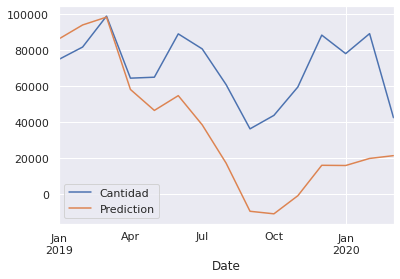

In [38]:
pd.concat([df_test.Cantidad,future_forecast.Prediction],axis=1).plot()

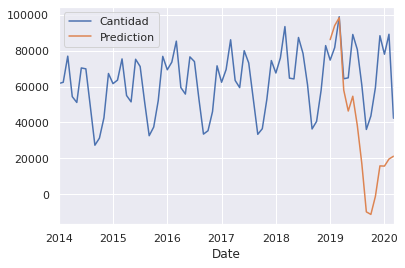

In [39]:
pd.concat([df.Cantidad,future_forecast.Prediction],axis=1).plot()

#### Modelo ARIMA(p,d,q)

In [40]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [41]:
model1= ARIMA(df.Cantidad, order=(1,0,1))
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Cantidad   No. Observations:                   75
Model:                     ARMA(1, 1)   Log Likelihood                -821.676
Method:                       css-mle   S.D. of innovations          13801.624
Date:                Tue, 22 Jun 2021   AIC                           1651.352
Time:                        21:00:01   BIC                           1660.622
Sample:                    01-01-2014   HQIC                          1655.053
                         - 03-01-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           6.235e+04   2879.009     21.658      0.000    5.67e+04     6.8e+04
ar.L1.Cantidad     0.1076      0.173      0.623      0.533      -0.231       0.446
ma.L1.Cantidad     0.6216      0.149      4.172      0.000       0.330       0.914
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            9.2909           +0.0000j            9.2909            0.0000
MA.1           -1.6087           +0.0000j            1.6087            0.5000
-----------------------------------------------------------------------------
"""

In [42]:
forcast1 = results1.predict(len(df),len(df)+36).rename('Forecast')

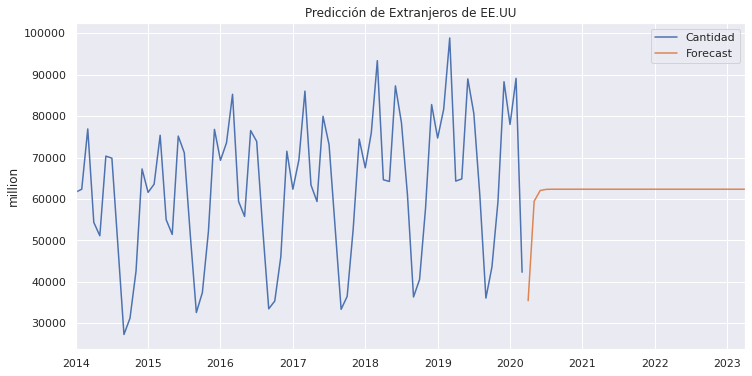

In [43]:
# Plot predictions against known values
title = 'Predicción de Extranjeros de EE.UU'
ylabel='million'
xlabel=''

ax = df['Cantidad'].plot(legend=True,figsize=(12,6),title=title)
forcast1.plot(legend=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### Modelo SARIMA(p,d,q)(P,D,Q)

In [44]:
# Herramientas
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [45]:
model2 = SARIMAX(df.Cantidad,
                order=(1,0,1),
                 seasonal_order=(0,1,1,12))
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Cantidad   No. Observations:                   75
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -659.201
Date:                            Tue, 22 Jun 2021   AIC                           1326.402
Time:                                    21:04:30   BIC                           1334.975
Sample:                                01-01-2014   HQIC                          1329.774
                                     - 03-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3836      2.619      0.146      0.884      -4.750       5.517
ma.L1         -0.2893      2.844     -0.102      0.919      -5.863       5.285
ma.S.L12       0.0180      0.111      0.161      0.872      -0.201       0.236
sigma2      7.166e+07   9.82e-07    7.3e+13      0.000    7.17e+07    7.17e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):              3672.15
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               7.15   Skew:                            -5.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.45e+29. Standard errors may be unstable.
"""

In [46]:
forcast2 = results2.predict(len(df),len(df)+36).rename('Forecast')

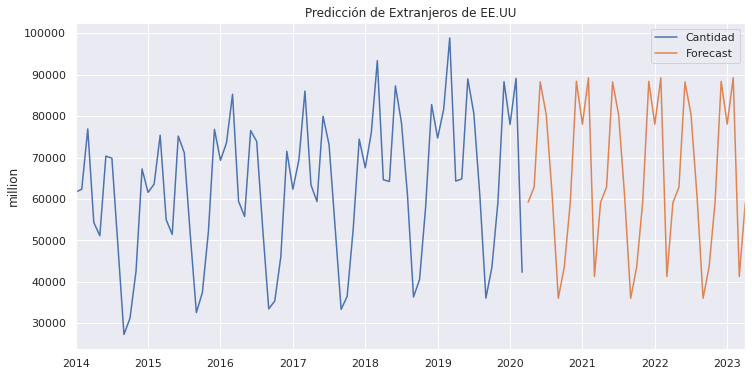

In [47]:
# Plot predictions against known values
title = 'Predicción de Extranjeros de EE.UU'
ylabel='million'
xlabel=''

ax = df['Cantidad'].plot(legend=True,figsize=(12,6),title=title)
forcast2.plot(legend=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

##### RESIDUOS

In [48]:
df['res'] = results2.resid.iloc[:]
df.tail()

,Cantidad,Mes,returns,res
Date,,,,
2019-11-01,59393,11,36.222477,1136.305380
2019-12-01,88275,12,48.628626,5146.372369
2020-01-01,77973,1,-11.670348,2588.418513
2020-02-01,89088,2,14.254934,6893.824636
2020-03-01,42331,3,-52.484061,-57421.504721


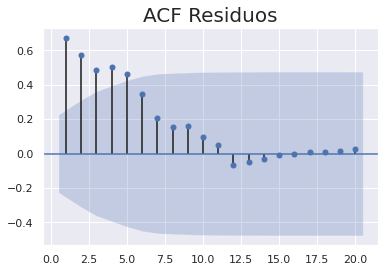

In [49]:
sgt.plot_acf(df.res, zero = False, lags = 20)
plt.title("ACF Residuos",size=20)
plt.show()

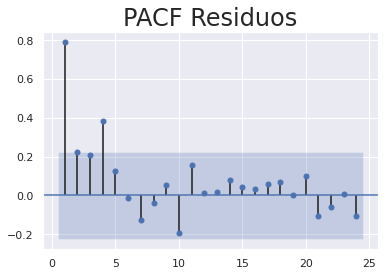

In [50]:
sgt.plot_pacf(df.res, lags = 24, zero = False, method = ('ols'))
plt.title("PACF Residuos", size = 24)
plt.show()

#### Holt Winters

In [51]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [52]:
df['TESmul12'] = ExponentialSmoothing(df['Cantidad'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

,Cantidad,Mes,returns,res,TESmul12
Date,,,,,
2014-01-01,61631,1,NaN,61631.000000,61931.246716
2014-02-01,62353,2,1.171488,56442.957459,71307.124377
2014-03-01,76894,3,23.320450,69365.276051,77595.608219
2014-04-01,54354,4,-29.313080,45015.328330,57225.368218
2014-05-01,51127,5,-5.937006,43359.380593,57064.494261


In [53]:
model_exp = ExponentialSmoothing(df['Cantidad'],seasonal_periods=12).fit()
model_add = ExponentialSmoothing(df['Cantidad'],trend='add',seasonal='add',seasonal_periods=12).fit()
model_mul = ExponentialSmoothing(df['Cantidad'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

In [54]:
forecast_add = model_add.forecast(36)
forecast_mul= model_mul.forecast(36)
forc=model_exp.predict(len(df),len(df)+36)

In [55]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

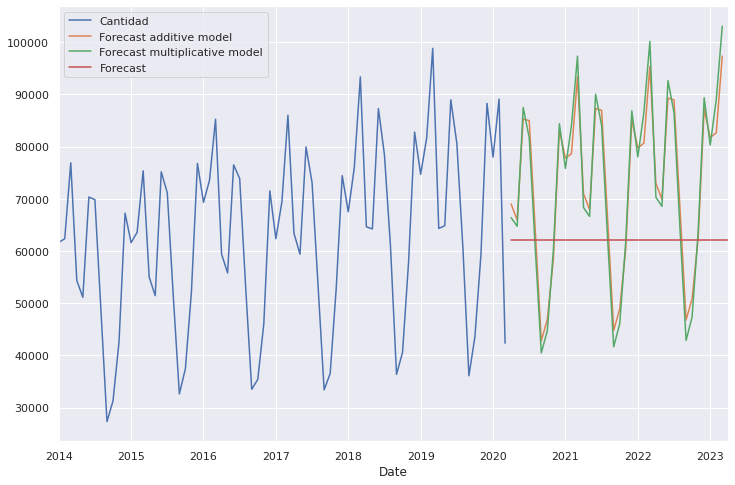

In [56]:
df['Cantidad'].plot(figsize=(12,8))
forecast_add.plot(label='Forecast additive model');
forecast_mul.plot(label='Forecast multiplicative model');
forc.plot(label='Forecast');
plt.legend(loc='upper left')

##### RESIDUOS

In [57]:
df['res_add'] = model_add.resid.iloc[:]
df.tail()

,Cantidad,Mes,returns,res,TESmul12,res_add
Date,,,,,,
2019-11-01,59393,11,36.222477,1136.305380,58905.862634,1983.509481
2019-12-01,88275,12,48.628626,5146.372369,81568.594628,5914.371687
2020-01-01,77973,1,-11.670348,2588.418513,74014.578816,758.707304
2020-02-01,89088,2,14.254934,6893.824636,81624.361664,10887.405610
2020-03-01,42331,3,-52.484061,-57421.504721,96781.216244,-51098.988369


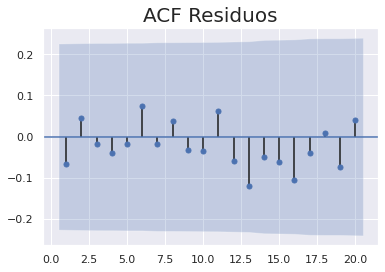

In [58]:
sgt.plot_acf(df.res_add, zero = False, lags = 20)
plt.title("ACF Residuos",size=20)
plt.show()

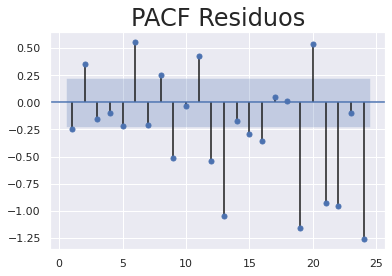

In [99]:
sgt.plot_pacf(df.res_add, lags = 24, zero = False, method = ('ols'))
plt.title("PACF Residuos", size = 24)
plt.show()